1. Fraud: A How-To Guide
In this problem you will use density modeling to try and ensure that there are no statistical irregularities in data that you have generated yourself.

Download the following data containing personal transactions over a period of several years.
Now build a density model for the number of transactions that occur in a single month.
Create plots showing the distribution that you've created.
Draw 10 samples from this density model using scikit.learn.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import pandas as pd

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/hueyning/cs156-ml/master/CS156%20Session%2010.1%20-%20Clustering%20models/transactions.csv")
df['Date'] = pd.to_datetime(df['Date'])

df.head()

,Date,Amount
0,2016-05-25,54241.35
1,2017-05-29,54008.83
2,2017-06-30,54008.82
3,2017-01-05,52704.37
4,2017-02-23,52704.36


Note: Cannot download the data so use the one online shared with Ha. 

In [4]:
from sklearn.neighbors import KernelDensity

month_trans = df.groupby(df['Date'].dt.strftime('%m'))['Amount'].count()

month_trans

Date
01    243
02    195
03    235
04    194
05    221
06    224
07    191
08    198
09    221
10    176
11    169
12    251
Name: Amount, dtype: int64

<BarContainer object of 12 artists>

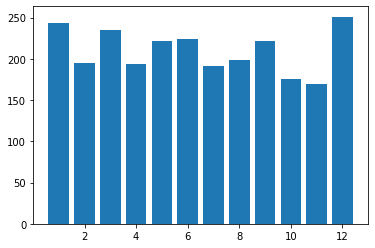

In [5]:
month = [i for i in range(1, 13)]
plt.bar(month, month_trans)

In [9]:
X = np.array(month_trans).reshape(-1, 1)
model = KernelDensity(kernel='gaussian').fit(X)
model.score_samples(X)

#withdraw 10 samples from the density model 
samples = model.sample(10)
print(samples)

[[235.20513216]
 [195.26912154]
 [168.82689292]
 [198.49349482]
 [176.6183928 ]
 [224.31783602]
 [193.20497925]
 [194.40292744]
 [222.77772207]
 [241.7914046 ]]


(array([2., 0., 1., 3., 0., 0., 3., 0., 1., 2.]),
 array([169. , 177.2, 185.4, 193.6, 201.8, 210. , 218.2, 226.4, 234.6,
        242.8, 251. ]),
 <a list of 10 Patch objects>)

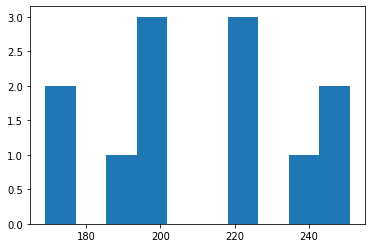

In [7]:
plt.hist(X)

## Q2 

In [ ]:
#Finn's code 
import numpy as np
import urllib.request

url = "https://course-resources.minerva.kgi.edu/uploaded_files/mke/rKwePr/questionnaire.csv"
f = urllib.request.urlopen(url)
answers = np.loadtxt(f, delimiter=",")
n_people, n_questions = answers.shape
n_clusters = 4

p_clusters = np.asarray([0.25, 0.25, 0.25, 0.25])
biases = np.random.beta(0.75, 0.75, size=(n_questions, n_clusters))


def expectation(answers, biases, p_clusters):
    # In this function we create our expectations.
    
    # find expectations for each person in the dataset
    lst_people = []
    for p_idx, person in enumerate(answers):
        # find expectations for each class for each person
        exp = [0, 0, 0, 0]
        numerators = []
        for c_idx, cls in enumerate(p_clusters):
            prob = 1

            # this part finds p(v^n | h) for the class given by c_idx
            for q_idx, question in enumerate(person):
                if answers[p_idx][q_idx]:
                    prob *= biases[q_idx][c_idx]
                else:
                    prob *= 1 - biases[q_idx][c_idx]

            numerators.append(prob * p_clusters[c_idx]) # the second term is p(h)

        # equivalent to p(vn | h)p(h)/(sum_h p(vn | h)*p(h))
        for n_idx, num in enumerate(numerators):
            exp[n_idx] = num / sum(numerators)

        lst_people.append(exp)

    people = np.array(lst_people)

    # normalize the distributions
    people = people / people.sum(axis=1, keepdims=1)
    return people


def maximization(answers, people):
    
    # people is equivalent to p(h | v^n)
    # In this part we have to answer the question: what biases create a distribution
    # that looks as much as possible like PEOPLE when fed ANSWERS

    def people_indicator(person_answer, answer):
        if (person_answer == answer).all():
            return 1
        else:
            return 0
    new_biases = []

    for ans_idx in range(answers.shape[0]):
        person_biases = []
        for c_idx in range(4):

            # numerator
            prob = 0
            for p_idx in range(people.shape[0]):
                prob += people[p_idx][c_idx]*people_indicator(answers[ans_idx], answers[p_idx])

            person_biases.append(prob)

        new_biases.append(person_biases)

    np_biases = np.array(new_biases)

    # 2have to use sklearn's normalize
    final_biases = normalize(np_biases, axis=1, norm='l1')
    return final_biases


for step in range(3):
    people = expectation(answers, biases, p_clusters)
    biases = maximization(answers, people)

print(biases)
print(people)


In [ ]:
# EM for survey data

import numpy as np
import urllib.request

url = "https://course-resources.minerva.kgi.edu/uploaded_files/mke/rKwePr/questionnaire.csv"
f = urllib.request.urlopen(url)
answers = np.loadtxt(f, delimiter=",")
n_people, n_questions = answers.shape
n_clusters = 4

p_clusters = np.asarray([0.25, 0.25, 0.25, 0.25])
biases = np.random.beta(0.75, 0.75, size=(n_questions, n_clusters))

def expectation(answers, biases, p_clusters):
    # In this function we create our expectations.
    people = np.zeros((n_people, n_clusters))
    log_bias = np.log(biases)
    log_other_bias = np.log1p(-biases)

    for a in range(n_clusters):
        term1 = (answers.T * log_bias[:, a:a + 1]).sum(axis=0)
        #conditional prob of answers given the cluster = p(v^n |h) p(h) numerator 
        term2 = ((1 - answers).T * log_other_bias[:, a:a + 1]).sum(axis=0)
        #conditional prob of answers given any other cluster = denominator * (-1) 
        people[:, a] = np.log(p_clusters[a]) + term1 + term2
        #joint prob of every cluster 
       
    # 

    people = people - people.max()
    people = np.exp(people)
    
    # # people = np.exp(answers@np.log(biases+1e-15) + (1-answers)@np.log(1-biases + 1e-15))@np.diag(p_clusters)
    #for i in range(0,n_people):
    #    for j in range(0, n_clusters):
    #        prob_i = np.prod(biases[answers[i,:] == 1,j])*np.prod(1-biases[answers[i,:] == 0,j])
    #         # Using bayes' rule, let's get the probability that class j resulted in this data
    #        people[i,j] = prob_i*p_clusters[j]
    
    #Normalize
    people = people / np.sum(people, axis=1, keepdims=True)
    return people


def maximization(answers, people):
    # Treating all the data as visible, now infer the parameters for the model.
    
    biases = np.zeros((n_questions, n_clusters))
    # for each class, compute the biases on each question
    biases =np.zeros((n_questions, n_clusters))
    
    for a in range(n_clusters):
        temp = people[:, a:a + 1]
        z = temp.sum()
        biases[:, a] = (temp * answers).sum(0) / z

    # Update the cluster probabilities
    sum_clusters = np.sum(people, axis = 0)
    cluster_prob = sum_clusters/np.sum(sum_clusters)
    
    # print(f"cluster priors: {cluster_prob}")
    
    return (biases, cluster_prob)

cluster_vals = p_clusters

for step in range(25):
    people = expectation(answers, biases, p_clusters)
    biases, p_clusters = maximization(answers, people)
    cluster_vals = np.vstack([cluster_vals,p_clusters])

print(biases)
print(p_clusters)


Debrief: https://docs.google.com/document/d/1fM1ga_lmm0MlGUG9RyhoDhc0S9JsOPGhOIvLSUcklrA/edit
